In [549]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
from typing import Optional, Union, Type, List, Dict

In [550]:
torch.set_default_dtype(torch.double)

In [551]:
df = pd.read_csv("../dataset/electricity.csv")

X = torch.tensor(df["1"].to_numpy()).unsqueeze(1)

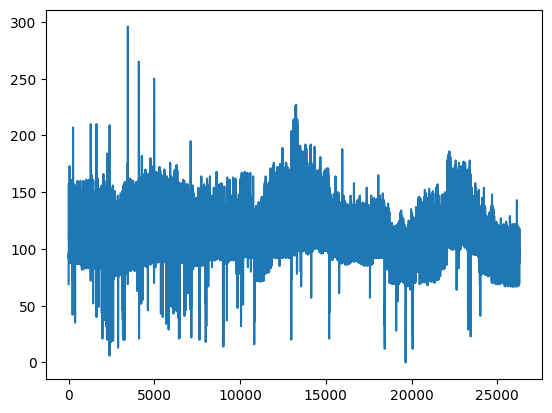

In [552]:
plt.plot(X)

In [553]:
stride = 1
kernel_size = 1023
padding = nn.ReplicationPad1d(padding=(kernel_size - stride) // 2)
avg_pool = nn.AvgPool1d(kernel_size=kernel_size, stride=stride)

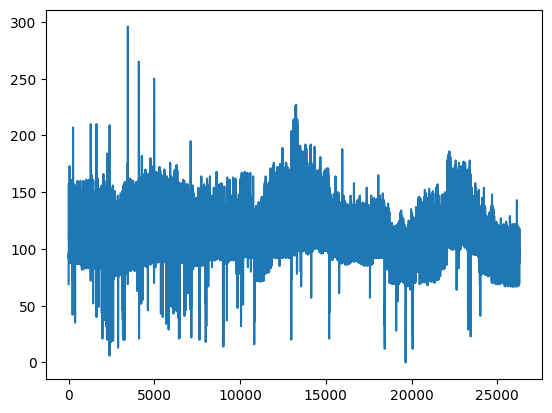

In [554]:
Xt = avg_pool(padding(X.permute(1, 0))).permute(1, 0)

plt.plot(X)

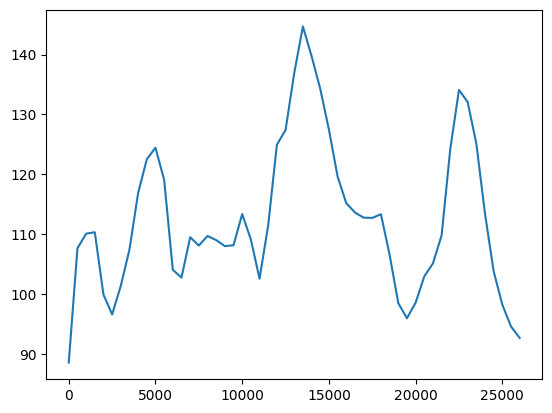

In [555]:
down_scale = 500
X_ds = Xt[::down_scale]
T_ds = torch.arange(len(X_ds), dtype=torch.double).unsqueeze(1) * down_scale
plt.plot(T_ds.squeeze(), X_ds.squeeze())

In [556]:
import kan

model_ds = kan.KAN(width=[1, 8, 8, 1])

dataset = {
    "train_input": T_ds,
    "test_input": T_ds,
    "train_label": X_ds,
    "test_label": X_ds,
}

checkpoint directory created: ./model
saving model version 0.0


In [557]:
fit = model_ds.fit(dataset, opt="LBFGS", steps=50, lamb=0.01)

| train_loss: 8.09e+00 | test_loss: 8.09e+00 | reg: 2.34e+01 | : 100%|█| 50/50 [00:14<00:00,  3.34it

saving model version 0.1


array(8.08601258)

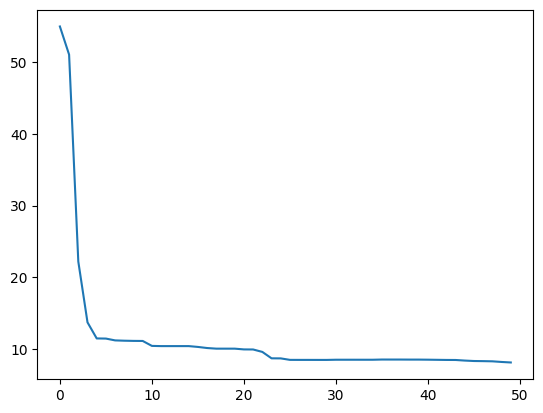

In [558]:
plt.plot(fit["train_loss"])
fit["train_loss"][-1]

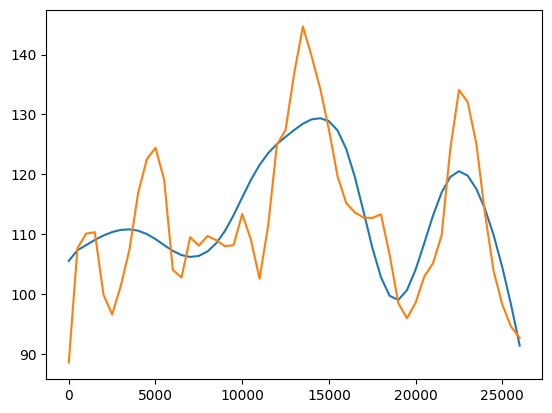

In [559]:
X_ds_pred: torch.Tensor = model_ds(T_ds).detach()
plt.plot(T_ds, X_ds_pred)
plt.plot(T_ds, X_ds)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_20208\4256791721.py:3: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  torch.range(


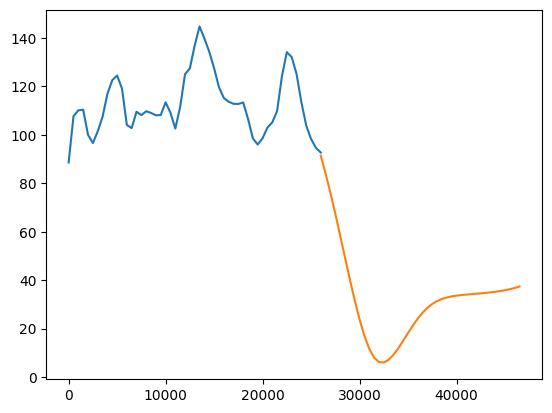

In [560]:
# 插值
T_ds_future = (
    torch.range(
        len(X_ds) - 1,
        len(X_ds) + 40,
        dtype=torch.double,
    ).unsqueeze(1)
    * down_scale
)


X_ds_pred_future = model_ds(T_ds_future).detach()
plt.plot(T_ds, X_ds)
plt.plot(T_ds_future, X_ds_pred_future)

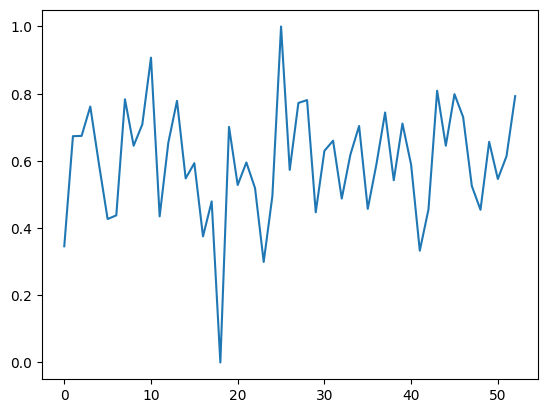

In [573]:
X_unknwon = X[::down_scale] - X_ds_pred
X_unknwon = (X_unknwon - torch.min(X_unknwon)) / (
    torch.max(X_unknwon) - torch.min(X_unknwon)
)
plt.plot(X_unknwon)